In [228]:
import pandas as pd
import re

In [229]:
df = pd.read_csv("food_coded.csv")

In [230]:
df.head()

,GPA,Gender,breakfast,calories_chicken,calories_day,calories_scone,coffee,comfort_food,comfort_food_reasons,comfort_food_reasons_coded,...,soup,sports,thai_food,tortilla_calories,turkey_calories,type_sports,veggies_day,vitamins,waffle_calories,weight
0,2.4,2,1,430,NaN,315.0,1,none,we dont have comfort,9.0,...,1.0,1.0,1,1165.0,345,car racing,5,1,1315,187
1,3.654,1,1,610,3.0,420.0,2,"chocolate, chips, ice cream","Stress, bored, anger",1.0,...,1.0,1.0,2,725.0,690,Basketball,4,2,900,155
2,3.3,1,1,720,4.0,420.0,2,"frozen yogurt, pizza, fast food","stress, sadness",1.0,...,1.0,2.0,5,1165.0,500,none,5,1,900,I'm not answering this.
3,3.2,1,1,430,3.0,420.0,2,"Pizza, Mac and cheese, ice cream",Boredom,2.0,...,1.0,2.0,5,725.0,690,NaN,3,1,1315,"Not sure, 240"
4,3.5,1,1,720,2.0,420.0,2,"Ice cream, chocolate, chips","Stress, boredom, cravings",1.0,...,1.0,1.0,4,940.0,500,Softball,4,2,760,190


In [231]:
df = df.iloc[:, [52, 41, 22, 20, 15, 2, 1, 7, 33, 60]]

In [232]:
df.head()

,sports,marital_status,exercise,employment,drink,breakfast,Gender,comfort_food,healthy_feeling,weight
0,1.0,1.0,1.0,3.0,1.0,1,2,none,2,187
1,1.0,2.0,1.0,2.0,2.0,1,1,"chocolate, chips, ice cream",5,155
2,2.0,2.0,2.0,3.0,1.0,1,1,"frozen yogurt, pizza, fast food",6,I'm not answering this.
3,2.0,2.0,3.0,3.0,2.0,1,1,"Pizza, Mac and cheese, ice cream",7,"Not sure, 240"
4,1.0,1.0,1.0,2.0,2.0,1,1,"Ice cream, chocolate, chips",6,190


In [233]:
df.loc[:, "is_active"] = df.sports == 1
df.loc[:, "is_single"] = df.marital_status == 1
df.loc[:, "is_sporty"] = df.exercise == 1
df.loc[:, "is_employed"] = (df.employment == 1) | (df.employment == 2)
df.loc[:, "is_healthy_eating"] = (df.drink == 1) & (df.breakfast == 1)
df.loc[:, "gender"] = df.Gender - 1
df.loc[:, "weight"] = df.weight.fillna(0).apply(lambda x: int(int(*re.findall("[0-9]+", str(x))) / 2.2))

In [234]:
cols = ["is_sporty", "is_single", "is_active", "is_employed", "gender", "is_healthy_eating", "weight", "comfort_food", "healthy_feeling"]


In [235]:
df = df[cols]

In [236]:
categories = set()

In [237]:
for _, row in df.comfort_food.iteritems():
    try:
        categories |= {a.lower().replace("and", "").strip() for a in row.split(",")}
    except:
        pass

In [238]:
veg = ["broccoli", "carrots", "cucumber", "fruit", "grapes", "watermelon"]
sport = ["almonds", "cereal", "yogurt", "garlic", "omelet"]
ten_min = ["burger", "burritos", "wings", "chips", "popcorn", "nugg", "chocolate", "cookie",
          "donut", "fast", "snacks", "micro"]
classic = ["beef", "grilled", "lasagn", "potato", "meat", "noodle", "peanut", "pasta", "rice", "soup", "toast"]
premium = ["curry", "chinese", "indian", "korean", "pizza", "spaghetti", "sushi", "wine", "truffles"]
holiday = ["ice", "cake", "brownies", "macaro", "mozzarella", "shake"]

In [239]:
for _, row in df.comfort_food.iteritems():
    try:
        user_input = [a.lower().replace("and", "").strip() for a in row.split(",")]
        result = [0 for _ in range(6)]
        for i, cat_gr in enumerate([veg, sport, ten_min, classic, premium, holiday]):
            for x in user_input:
                for cat in cat_gr:
                    if cat in x:
                        result[i] = 1
        for j in range(len(result)):
            df.loc[_, f'target_{j}'] = result[j]
    except:
        for i in range(6):
            df.loc[i, f'target_{i}'] = 0

In [240]:
X = df.loc[:, cols[:7]].astype(int)
y = df.loc[:, [f'target_{i}' for i in range(6)]].fillna(0).astype(int)

In [250]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [242]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [277]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

In [251]:
pipe = Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_jobs=-1))])

In [274]:
pipe_grid = {"knn__n_neighbors": range(22, 102, 5), 
             "knn__metric": ["minkowski", "jaccard", "manhattan"]}

In [275]:
pipe_grids = GridSearchCV(pipe, pipe_grid, cv=5, n_jobs=-1, verbose=1)

In [276]:
pipe_grids.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/usr/local/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/usr/local/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/usr/local/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/usr/local/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/usr/local/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/usr/local/lib/python3.6/site-packages/sklear

KeyboardInterrupt: 

In [ ]:
pipe_grids.best_score_, pipe_grids.best_params_

In [289]:
import numpy as np

In [329]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

In [330]:
pipe = Pipeline([("ros", RandomOverSampler()), ("rf", RandomForestClassifier())])

In [331]:
rf_grid = GridSearchCV(pipe, {"rf__n_estimators": [20], 
                                                  "rf__max_features": [4],
                                                 "rf__max_depth": range(10, 50, 5)}, 
                       cv=3, n_jobs=-1, verbose=1, return_train_score=True)

In [332]:
rf_grid.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x108225f60, file "/usr...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/usr/local/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/usr/local/lib/python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x108225f60, file "/usr...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/usr/local/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/usr/local/lib/python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/usr/local/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/usr/local/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    481         if self.poller is not None:
    482             self.poller.start()
    483         self.kernel.start()
    484         self.io_loop = ioloop.IOLoop.current()
    485         try:
--> 486             self.io_loop.start()
        self.io_loop.start = <bound method PollIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    487         except KeyboardInterrupt:
    488             pass
    489 
    490 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/usr/local/lib/python3.6/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/usr/local/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
/usr/local/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'rf_grid.fit(X_train, y_train)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 3, 3, 18, 29, 30, 27453, tzinfo=tzutc()), 'msg_id': '696e6187f2a143c881b69e5ee50eedbd', 'msg_type': 'execute_request', 'session': '007b093af1f84f7e8bac66aec489acbf', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '696e6187f2a143c881b69e5ee50eedbd', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'007b093af1f84f7e8bac66aec489acbf']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'rf_grid.fit(X_train, y_train)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 3, 3, 18, 29, 30, 27453, tzinfo=tzutc()), 'msg_id': '696e6187f2a143c881b69e5ee50eedbd', 'msg_type': 'execute_request', 'session': '007b093af1f84f7e8bac66aec489acbf', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '696e6187f2a143c881b69e5ee50eedbd', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'007b093af1f84f7e8bac66aec489acbf'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'rf_grid.fit(X_train, y_train)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 3, 3, 18, 29, 30, 27453, tzinfo=tzutc()), 'msg_id': '696e6187f2a143c881b69e5ee50eedbd', 'msg_type': 'execute_request', 'session': '007b093af1f84f7e8bac66aec489acbf', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '696e6187f2a143c881b69e5ee50eedbd', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/usr/local/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='rf_grid.fit(X_train, y_train)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'rf_grid.fit(X_train, y_train)'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/usr/local/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('rf_grid.fit(X_train, y_train)',), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('rf_grid.fit(X_train, y_train)',)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='rf_grid.fit(X_train, y_train)', store_history=True, silent=False, shell_futures=True)
   2723                 self.displayhook.exec_result = result
   2724 
   2725                 # Execute the user code
   2726                 interactivity = "none" if silent else self.ast_node_interactivity
   2727                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2728                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2729                 
   2730                 self.last_execution_succeeded = not has_raised
   2731                 self.last_execution_result = result
   2732 

...........................................................................
/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Expr object>], cell_name='<ipython-input-332-d87c32efa77e>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 1147baf98, execution_..._before_exec=None error_in_exec=None result=None>)
   2851                     return True
   2852 
   2853             for i, node in enumerate(to_run_interactive):
   2854                 mod = ast.Interactive([node])
   2855                 code = compiler(mod, cell_name, "single")
-> 2856                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x113bd0ed0, file "<ipython-input-332-d87c32efa77e>", line 1>
        result = <ExecutionResult object at 1147baf98, execution_..._before_exec=None error_in_exec=None result=None>
   2857                     return True
   2858 
   2859             # Flush softspace
   2860             if softspace(sys.stdout, 0):

...........................................................................
/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x113bd0ed0, file "<ipython-input-332-d87c32efa77e>", line 1>, result=<ExecutionResult object at 1147baf98, execution_..._before_exec=None error_in_exec=None result=None>)
   2905         outflag = True  # happens in more places, so it's easier as default
   2906         try:
   2907             try:
   2908                 self.hooks.pre_run_code_hook()
   2909                 #rprint('Running code', repr(code_obj)) # dbg
-> 2910                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x113bd0ed0, file "<ipython-input-332-d87c32efa77e>", line 1>
        self.user_global_ns = {'ALLOW_THREADS': 1, 'Annotation': <class 'matplotlib.text.Annotation'>, 'Arrow': <class 'matplotlib.patches.Arrow'>, 'Artist': <class 'matplotlib.artist.Artist'>, 'AutoLocator': <class 'matplotlib.ticker.AutoLocator'>, 'Axes': <class 'matplotlib.axes._axes.Axes'>, 'AxisError': <class 'numpy.core._internal.AxisError'>, 'BUFSIZE': 8192, 'Button': <class 'matplotlib.widgets.Button'>, 'CLIP': 0, ...}
        self.user_ns = {'ALLOW_THREADS': 1, 'Annotation': <class 'matplotlib.text.Annotation'>, 'Arrow': <class 'matplotlib.patches.Arrow'>, 'Artist': <class 'matplotlib.artist.Artist'>, 'AutoLocator': <class 'matplotlib.ticker.AutoLocator'>, 'Axes': <class 'matplotlib.axes._axes.Axes'>, 'AxisError': <class 'numpy.core._internal.AxisError'>, 'BUFSIZE': 8192, 'Button': <class 'matplotlib.widgets.Button'>, 'CLIP': 0, ...}
   2911             finally:
   2912                 # Reset our crash handler in place
   2913                 sys.excepthook = old_excepthook
   2914         except SystemExit as e:

...........................................................................
/Users/thepowerfuldeez/Dropbox/Projects/pp-ml/<ipython-input-332-d87c32efa77e> in <module>()
----> 1 rf_grid.fit(X_train, y_train)

...........................................................................
/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_search.py in fit(self=GridSearchCV(cv=3, error_score='raise',
       e...train_score=True,
       scoring=None, verbose=1), X=     is_sporty  is_single  is_active  is_employe...3       55  
119      84  

[93 rows x 7 columns], y=     target_0  target_1  target_2  target_3  tar...     1         1         1

[93 rows x 6 columns], groups=None, **fit_params={})
    634                                   return_train_score=self.return_train_score,
    635                                   return_n_test_samples=True,
    636                                   return_times=True, return_parameters=False,
    637                                   error_score=self.error_score)
    638           for parameters, (train, test) in product(candidate_params,
--> 639                                                    cv.split(X, y, groups)))
        cv.split = <bound method _BaseKFold.split of KFold(n_splits=3, random_state=None, shuffle=False)>
        X =      is_sporty  is_single  is_active  is_employe...3       55  
119      84  

[93 rows x 7 columns]
        y =      target_0  target_1  target_2  target_3  tar...     1         1         1

[93 rows x 6 columns]
        groups = None
    640 
    641         # if one choose to see train score, "out" will contain train score info
    642         if self.return_train_score:
    643             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
/usr/local/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Sat Mar  3 21:29:30 2018
PID: 7309                Python 3.6.3: /usr/local/opt/python3/bin/python3.6
...........................................................................
/usr/local/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (Pipeline(memory=None,
     steps=[('ros', Random...None, verbose=0,
            warm_start=False))]),      is_sporty  is_single  is_active  is_employe...3       55  
119      84  

[93 rows x 7 columns],      target_0  target_1  target_2  target_3  tar...     1         1         1

[93 rows x 6 columns], {'score': <function _passthrough_scorer>}, array([31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 4...     82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 1... 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]), 1, {'rf__max_depth': 10, 'rf__max_features': 4, 'rf__n_estimators': 20}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': True})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/usr/local/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (Pipeline(memory=None,
     steps=[('ros', Random...None, verbose=0,
            warm_start=False))]),      is_sporty  is_single  is_active  is_employe...3       55  
119      84  

[93 rows x 7 columns],      target_0  target_1  target_2  target_3  tar...     1         1         1

[93 rows x 6 columns], {'score': <function _passthrough_scorer>}, array([31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 4...     82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 1... 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]), 1, {'rf__max_depth': 10, 'rf__max_features': 4, 'rf__n_estimators': 20})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': True}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=Pipeline(memory=None,
     steps=[('ros', Random...None, verbose=0,
            warm_start=False))]), X=     is_sporty  is_single  is_active  is_employe...3       55  
119      84  

[93 rows x 7 columns], y=     target_0  target_1  target_2  target_3  tar...     1         1         1

[93 rows x 6 columns], scorer={'score': <function _passthrough_scorer>}, train=array([31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 4...     82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92]), test=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 1... 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]), verbose=1, parameters={'rf__max_depth': 10, 'rf__max_features': 4, 'rf__n_estimators': 20}, fit_params={}, return_train_score=True, return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    453 
    454     try:
    455         if y_train is None:
    456             estimator.fit(X_train, **fit_params)
    457         else:
--> 458             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method Pipeline.fit of Pipeline(memory=No...one, verbose=0,
            warm_start=False))])>
        X_train =      is_sporty  is_single  is_active  is_employe...3       55  
119      84  

[62 rows x 7 columns]
        y_train =      target_0  target_1  target_2  target_3  tar...     1         1         1

[62 rows x 6 columns]
        fit_params = {}
    459 
    460     except Exception as e:
    461         # Note fit time as time until error
    462         fit_time = time.time() - start_time

...........................................................................
/usr/local/lib/python3.6/site-packages/imblearn/pipeline.py in fit(self=Pipeline(memory=None,
     steps=[('ros', Random...None, verbose=0,
            warm_start=False))]), X=     is_sporty  is_single  is_active  is_employe...3       55  
119      84  

[62 rows x 7 columns], y=     target_0  target_1  target_2  target_3  tar...     1         1         1

[62 rows x 6 columns], **fit_params={})
    237         -------
    238         self : Pipeline
    239             This estimator
    240 
    241         """
--> 242         Xt, yt, fit_params = self._fit(X, y, **fit_params)
        Xt = undefined
        yt = undefined
        fit_params = {}
        self._fit = <bound method Pipeline._fit of Pipeline(memory=N...one, verbose=0,
            warm_start=False))])>
        X =      is_sporty  is_single  is_active  is_employe...3       55  
119      84  

[62 rows x 7 columns]
        y =      target_0  target_1  target_2  target_3  tar...     1         1         1

[62 rows x 6 columns]
    243         if self._final_estimator is not None:
    244             self._final_estimator.fit(Xt, yt, **fit_params)
    245         return self
    246 

...........................................................................
/usr/local/lib/python3.6/site-packages/imblearn/pipeline.py in _fit(self=Pipeline(memory=None,
     steps=[('ros', Random...None, verbose=0,
            warm_start=False))]), X=     is_sporty  is_single  is_active  is_employe...3       55  
119      84  

[62 rows x 7 columns], y=     target_0  target_1  target_2  target_3  tar...     1         1         1

[62 rows x 6 columns], **fit_params={})
    200                         cloned_transformer, None, Xt, yt,
    201                         **fit_params_steps[name])
    202                 elif hasattr(cloned_transformer, "sample"):
    203                     Xt, yt, fitted_transformer = fit_sample_one_cached(
    204                         cloned_transformer, Xt, yt,
--> 205                         **fit_params_steps[name])
        fit_params_steps = {'rf': {}, 'ros': {}}
        name = 'ros'
    206                 # Replace the transformer of the step with the fitted
    207                 # transformer. This is necessary when loading the transformer
    208                 # from the cache.
    209                 self.steps[step_idx] = (name, fitted_transformer)

...........................................................................
/usr/local/lib/python3.6/site-packages/sklearn/externals/joblib/memory.py in __call__(self=NotMemorizedFunc(func=<function _fit_sample_one at 0x1147af9d8>), *args=(RandomOverSampler(random_state=None, ratio='auto'),      is_sporty  is_single  is_active  is_employe...3       55  
119      84  

[62 rows x 7 columns],      target_0  target_1  target_2  target_3  tar...     1         1         1

[62 rows x 6 columns]), **kwargs={})
    357     # Should be a light as possible (for speed)
    358     def __init__(self, func):
    359         self.func = func
    360 
    361     def __call__(self, *args, **kwargs):
--> 362         return self.func(*args, **kwargs)
        self.func = <function _fit_sample_one>
        args = (RandomOverSampler(random_state=None, ratio='auto'),      is_sporty  is_single  is_active  is_employe...3       55  
119      84  

[62 rows x 7 columns],      target_0  target_1  target_2  target_3  tar...     1         1         1

[62 rows x 6 columns])
        kwargs = {}
    363 
    364     def call_and_shelve(self, *args, **kwargs):
    365         return NotMemorizedResult(self.func(*args, **kwargs))
    366 

...........................................................................
/usr/local/lib/python3.6/site-packages/imblearn/pipeline.py in _fit_sample_one(sampler=RandomOverSampler(random_state=None, ratio='auto'), X=     is_sporty  is_single  is_active  is_employe...3       55  
119      84  

[62 rows x 7 columns], y=     target_0  target_1  target_2  target_3  tar...     1         1         1

[62 rows x 6 columns], **fit_params={})
    598         return res, transformer
    599     return res * weight, transformer
    600 
    601 
    602 def _fit_sample_one(sampler, X, y, **fit_params):
--> 603     X_res, y_res = sampler.fit_sample(X, y, **fit_params)
        X_res = undefined
        y_res = undefined
        sampler.fit_sample = <bound method SamplerMixin.fit_sample of RandomOverSampler(random_state=None, ratio='auto')>
        X =      is_sporty  is_single  is_active  is_employe...3       55  
119      84  

[62 rows x 7 columns]
        y =      target_0  target_1  target_2  target_3  tar...     1         1         1

[62 rows x 6 columns]
        fit_params = {}
    604 
    605     return X_res, y_res, sampler
    606 
    607 

...........................................................................
/usr/local/lib/python3.6/site-packages/imblearn/base.py in fit_sample(self=RandomOverSampler(random_state=None, ratio='auto'), X=     is_sporty  is_single  is_active  is_employe...3       55  
119      84  

[62 rows x 7 columns], y=     target_0  target_1  target_2  target_3  tar...     1         1         1

[62 rows x 6 columns])
     83         y_resampled : array-like, shape (n_samples_new,)
     84             The corresponding label of `X_resampled`
     85 
     86         """
     87 
---> 88         return self.fit(X, y).sample(X, y)
        self.fit = <bound method BaseSampler.fit of RandomOverSampler(random_state=None, ratio='auto')>
        X =      is_sporty  is_single  is_active  is_employe...3       55  
119      84  

[62 rows x 7 columns]
        y.sample = <bound method NDFrame.sample of      target_0  t...    1         1         1

[62 rows x 6 columns]>
        y =      target_0  target_1  target_2  target_3  tar...     1         1         1

[62 rows x 6 columns]
     89 
     90     @abstractmethod
     91     def _sample(self, X, y):
     92         """Resample the dataset.

...........................................................................
/usr/local/lib/python3.6/site-packages/imblearn/base.py in fit(self=RandomOverSampler(random_state=None, ratio='auto'), X=     is_sporty  is_single  is_active  is_employe...3       55  
119      84  

[62 rows x 7 columns], y=     target_0  target_1  target_2  target_3  tar...     1         1         1

[62 rows x 6 columns])
    152         -------
    153         self : object,
    154             Return self.
    155 
    156         """
--> 157         X, y = check_X_y(X, y, accept_sparse=['csr', 'csc'])
        X =      is_sporty  is_single  is_active  is_employe...3       55  
119      84  

[62 rows x 7 columns]
        y =      target_0  target_1  target_2  target_3  tar...     1         1         1

[62 rows x 6 columns]
    158         y = check_target_type(y)
    159         self.X_hash_, self.y_hash_ = hash_X_y(X, y)
    160         # self.sampling_type is already checked in check_ratio
    161         self.ratio_ = check_ratio(self.ratio, y, self._sampling_type)

...........................................................................
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py in check_X_y(X=array([[  1,   1,   0,   1,   0,   1,  75],
    ...55],
       [  0,   0,   1,   1,   1,   1,  84]]), y=     target_0  target_1  target_2  target_3  tar...     1         1         1

[62 rows x 6 columns], accept_sparse=['csr', 'csc'], dtype='numeric', order=None, copy=False, force_all_finite=True, ensure_2d=True, allow_nd=False, multi_output=False, ensure_min_samples=1, ensure_min_features=1, y_numeric=False, warn_on_dtype=False, estimator=None)
    573                     ensure_min_features, warn_on_dtype, estimator)
    574     if multi_output:
    575         y = check_array(y, 'csr', force_all_finite=True, ensure_2d=False,
    576                         dtype=None)
    577     else:
--> 578         y = column_or_1d(y, warn=True)
        y =      target_0  target_1  target_2  target_3  tar...     1         1         1

[62 rows x 6 columns]
    579         _assert_all_finite(y)
    580     if y_numeric and y.dtype.kind == 'O':
    581         y = y.astype(np.float64)
    582 

...........................................................................
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py in column_or_1d(y=     target_0  target_1  target_2  target_3  tar...     1         1         1

[62 rows x 6 columns], warn=True)
    609                           " expected. Please change the shape of y to "
    610                           "(n_samples, ), for example using ravel().",
    611                           DataConversionWarning, stacklevel=2)
    612         return np.ravel(y)
    613 
--> 614     raise ValueError("bad input shape {0}".format(shape))
        shape = (62, 6)
    615 
    616 
    617 def check_random_state(seed):
    618     """Turn seed into a np.random.RandomState instance

ValueError: bad input shape (62, 6)
___________________________________________________________________________

In [316]:
rf_grid.best_score_

0.12903225806451613

In [306]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

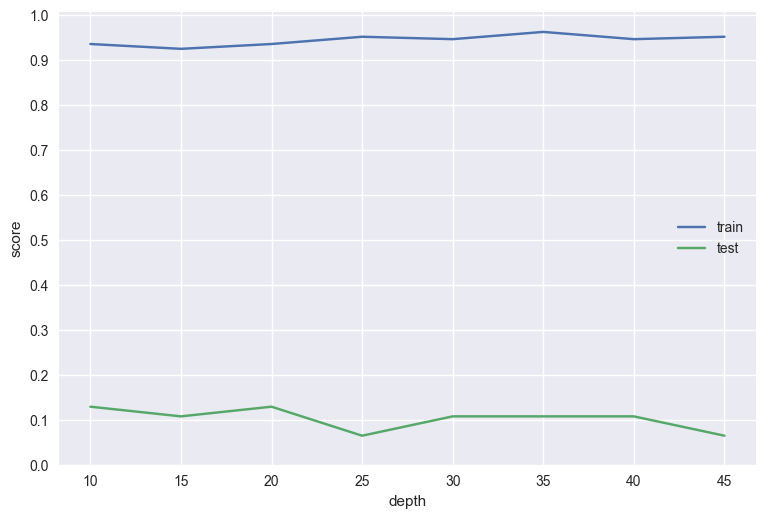

In [324]:
plt.plot(range(10, 50, 5), rf_grid.cv_results_['mean_train_score'], label="train")
plt.plot(range(10, 50, 5), rf_grid.cv_results_['mean_test_score'], label="test")
plt.ylabel("score")
plt.xlabel("depth")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend()

In [326]:
rf_grid.predict(X_test)

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 1., 0.],
       [0., 0., 1., 1., 0., 0.],
       [0., 0., 1., 0., 1., 1.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 1., 1.],
       [0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 1., 1., 0.],
       [0., 0., 1., 0., 1., 0.],
       [0., 0., 1., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 1., 0.],
       [0., 0., 1., 0., 1., 0.],
       [0., 0., 1., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 1., 1.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 0., 0., 1.],
       [0.

сильные фичи
* 52 - спорт да(1) , нет (2, 99)
* 41 - отношения один(1), остальное(2,3,4,5,6)
* 22 - спорт да (1,2), нет (3,4,5)

слабые фичи
* 20 - работа занят(1,2), нет(3,4)
* 15 - здоровое питание да(1), нет(2)
* 3 - здоровый завтрак да(1), нет(2)
* 2 - пол ж(1), м(2)

таргет фичи
* 8 - комфортная еда
* 33 - ощущения здоровья от 1 очень здоров до 10 нездоров